# Chapter 4. 모델 훈련

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import os
import numpy as np
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

---
## 4.4 학습곡선

![Figure4-14](./images/Figure4-14.png)
**<center>그림 4-14 고차(300차) 다항 회귀</center>**

(80, 1) (20, 1) (80, 1) (20, 1)


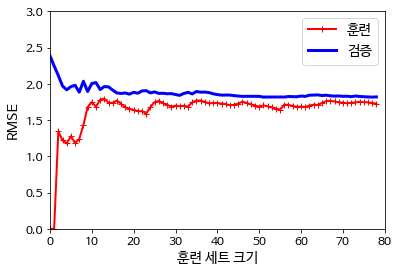

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("훈련 세트 크기", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

#### ▣ 단순 선형 회귀 모델(직선)의 학습 곡선
+ 훈련 세트
    + 샘플이 하나 혹은 두 개일 때는 모델이 완벽하게 작동
    + 샘플이 추가됨에 따라 노이즈도 있고 데이터가 비선형이기 때문에 모델이 완벽히 학습하는 것이 불가능
    + 오차가 계속 상승하다가 어느 정도를 유지
+ 검증 세트
    + 샘플의 수가 적으면 제대로 일반화될 수 없어서 검증 오차가 초기에 매우 큼
    + 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소
    + 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워짐
+ 과소적합 모델의 전형적인 모습  
→ 훈련 샘플을 더 추가해도 효과가 없음, 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 함

---
#### ▣ 10차 다항 회귀 모델의 학습 곡선

(80, 1) (20, 1) (80, 1) (20, 1)


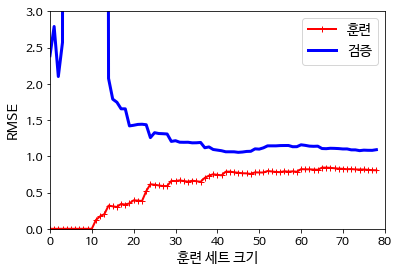

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

+ 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
+ 두 곡선 사이에 공간이 있음. 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻으로 과대적합 모델의 특징임. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐
+ 과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것

---
#### ▣ 편향/분산 트레이드오프

※ 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있음
+ **편향**  
일반화 오차 중에서 편향은 잘못된 가정으로 인한 것임. (예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우) 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉬움
+ **분산**  
분산<sup>variance</sup>은 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타남. 자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있음
+ **줄일 수 없는 오차**  
줄일 수 없는 오차<sup>irreducible error</sup>는 데이터 자체에 있는 노이즈 때문에 발생함. 이 오차를 줄일 수 있는 유일한 방법은 데이터에서 노이즈를 제거하는 것(예를 들어 고장 난 센서 같은 데이터 소스를 고치거나 이상치를 감지해 제거함)

※ 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어듬. 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아짐.

---
## 4.5 규제가 있는 선형 모델

### 4.5.1 릿지 회귀

▣ **릿지 회귀**(또는 **티호노프**<sup>Tikhonov</sup> 규제) : 규제가 추가된 선형 회귀
+ 규제항 : 가중치 벡터의 $l_2$ 노름의 제곱을 2로 나눈 것을 사용
+ $\alpha$로 모델을 얼마나 많이 규제할지 조절
+ 규제항은 훈련하는 동안에만 비용 함수에 추가됨
+ 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가

![Equation4-8](./images/Equation4-8.png)
**<center>식 4-8 릿지 회귀의 비용 함수</center>**

---
![Figure4-17](./images/Figure4-17.png)
**<center>그림 4-17 릿지 회귀</center>**
+ 왼쪽 그래프는 평범한 릿지 모델
+ 오른쪽 그래프는 PolynomialFeatures(degree=10)을 사용해 데이터를 확장하고 StandardScaler를 사용해 스케일을 조정한 릿지 모델
+ $\alpha$가 커질수록 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨  
 → 모델의 분산은 줄지만 편향은 커짐

---
![Equation4-9](./images/Equation4-9.png)
**<center>식 4-9 릿지 회귀의 정규방정식</center>**
+ A는 편향에 해당하는 맨 왼쪽 위의 원소가 0인 $(n+1)\times(n+1)$의 단위행렬<sup>identity matrix</sup>

In [4]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

In [5]:
# 정규방정식을 사용한 릿지 회귀
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

+ solver 매개변수의 기본값은 'auto'며 희소 행렬이나 특이 행렬(singular matrix)이 아닐 경우 'cholesky'가 됨

In [6]:
# 확률적 경사 하강법을 사용한 릿지 회귀
sgd_reg = SGDRegressor(max_iter=5, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.13500145])

In [7]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

+ 확률적 평균 경사 하강법(Stochastic Average Gradient Descent, SAG) - SGD의 변종  
: 현재 그래디언트와 이전 스텝에서 구한 모든 그래디언트를 합해서 평균한 값으로 모델 파라미터를 갱신

---
### 4.5.2 라쏘 회귀

▣ **라쏘**<sup>Least Absolute and Selection Operator</sup>(Lasso) **회귀** : 선형 회귀의 또 다른 규제된 버전
+ 규제항 : 가중치 벡터의 $l_1$ 노름을 사용
![Equation4-10](./images/Equation4-10.png)
**<center>식 4-10 라쏘 회귀의 비용함수</center>**

---
![Figure4-18](./images/Figure4-18.png)
**<center>그림 4-18 라쏘 회귀</center>**
+ 덜 중요한 특성의 가중치를 완전히 제거하려고 함(즉, 가중치가 0이 됨)
+ 자동으로 특성 선택을 하고 **희소 모델**<sup>sparse model</sup>을 만듬(즉, 0이 아닌 특성의 가중치가 적음)

---
![Figure4-19](./images/Figure4-19.png)
**<center>그림 4-19 라쏘 및 릿지 규제</center>**
+ 파란 배경의 등고선(타원형) : 규제가 없는($\alpha$=0) MSE 비용 함수
+ 하얀색 원 : 비용 함수에 대한 배치 경사 하강법의 경로
+ 무지개색 등고선 : $l_1$(다이아몬드형, 왼쪽 위), $l_2$(타원형, 왼쪽 아래) 페널티에 대한($\alpha$→**∞**) 배치 경사 하강법의 경로
+ 오른쪽 위 그래프 : $\alpha$=0.5의 $l_1$ 페널티가 더해진 비용 함수 → 라쏘 회귀의 비용함수
+ 오른쪽 아래 그래프 : $\alpha$=0.5의 $l_2$ 페널티가 더해진 비용 함수 → 릿지 회귀의 비용함수  
※ 규제가 있는 경우의 최젓값이 규제가 없는 경우보다 $\theta$값이 0에 더 가까움(가중치가 완전히 제거되지는 않음)

---
+ 라쏘의 비용 함수는 $\theta_i$=0($i$=1~n)에서 미분 불가능  
→ **서브그래디언트 벡터**<sup>subgradient vector</sup> **g**를 사용하여 해결
![Equation4-11](./images/Equation4-11.png)
**<center>식 4-11 라쏘 회귀의 서브그래디언트 벡터</center>**

In [8]:
from sklearn.linear_model import Lasso

# 정규방정식을 사용한 라쏘 회귀
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [9]:
# 확률적 경사 하강법을 사용한 라쏘 회귀
sgd_reg = SGDRegressor(max_iter=5, penalty="l1", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.13498188])

---
### 4.5.3 엘라스틱넷

▣ **엘라스틱넷**<sup>Elastic Net</sup> : 릿지 회귀와 라쏘 회귀를 절충한 모델
+ 규제항은 릿지 회귀와 라쏘 회귀의 규제항을 단순히 더해서 사용
+ 혼합 정도는 혼합 비율 r을 사용해 조절
    + r=0 → 릿지 회귀
    + r=1 → 라쏘 회귀
![Equation4-12](./images/Equation4-12.png)
**<center>식 4-12 엘라스틱넷 비용 함수</center>**

In [10]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

---
▣ **보통의 선형 회귀, 릿지, 라쏘, 엘라스틱넷**
+ 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 함
+ 릿지가 기본, 실제로 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 좋음(불필요한 특성의 가중치를 0으로 만듦)
+ 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘보다 엘라스틱넷이 선호됨(라쏘는 특성 수가 샘플 수(n)보다 많으면 최대 n개의 특성을 선택함. 또, 여러 특성이 강하게 연관되어 있으면 이들 중 임의의 특성 하나를 선택함)

---
### 4.5.4 조기 종료

▣ **조기 종료**<sup>early stopping</sup> : 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 방식
![Figure4-20](./images/Figure4-20.png)
**<center>그림 4-20 조기 종료 규제</center>**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 이어서 학습합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

best_epoch, best_model

(287,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
        verbose=0, warm_start=True))

**※** warm_start=True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감  
◈ SGDRegressor : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

---
### 4.6 로지스틱 회귀

▣ **로지스틱 회귀**<sup>Logistic Regression</sup>(또는 **로짓 회귀**<sup>Logit Regression</sup>) : 샘플이 특정 클래스에 속할 확률을 추정  
e.g.) 이메일이 스팸일 확률(이진 분류기)

---
### 4.6.1 확률 추정

![Equation4-13](./images/Equation4-13.png)
**<center>식 4-13 로지스틱 회귀 모델의 확률 추정(벡터 표현식)</center>**
**※** $\sigma(·)$ → logistic 또는 logit이라고 부름  
: 0과 1사이의 값을 출력하는 **시그모이드 함수**<sup>sigmoid function</sup> (S자 형태)
![Equation4-14](./images/Equation4-14.png)
**<center>식 4-14 로지스틱 함수</center>**
![Figure4-21](./images/Figure4-21.png)
**<center>그림 4-21 로지스틱 함수</center>**
![Equation4-15](./images/Equation4-15.png)
**<center>식 4-15 로지스틱 회귀 모델 예측</center>**

---
### 4.6.2 훈련과 비용 함수

![Equation4-16](./images/Equation4-16.png)
**<center>식 4-16 하나의 훈련 샘플에 대한 비용 함수</center>**


![Equation4-17](./images/Equation4-17.png)
**<center>식 4-17 로지스틱 회귀의 비용 함수(로그 손실<sup>log loss</sup>)</center>**


![Equation4-18](./images/Equation4-18.png)
**<center>식 4-18 로지스틱 비용 함수의 편도함수</center>**

---
### 4.6.3 결정 경계

In [12]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['feature_names', 'target_names', 'target', 'filename', 'data', 'DESCR']

In [13]:
iris.data.shape, iris.target.shape

((150, 4), (150,))

In [14]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [15]:
X = iris["data"][:, 3:]  # 꽃잎 넓이
y = (iris["target"] == 2).astype(np.int)  # Iris-Virginica이면 1 아니면 0

X.shape, y.shape

((150, 1), (150,))

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

+ 다른 선형 모델처럼 로지스틱 회귀 모델도 $l_1, l_2$ 페널티를 사용하여 규제할 수 있음
+ 사이킷런은 $l_2$ 페널티를 기본으로 함
+ LogisticRegression 모델의 규제 강도를 조절하는 하이퍼파라미터는  
alpha가 아니고 그 역수에 해당하는 C(높을수록 규제가 줄어듦)  

**※** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

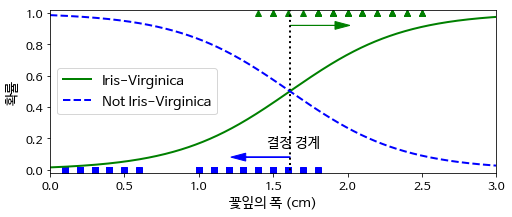

In [17]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "결정 경계", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("꽃잎의 폭 (cm)", fontsize=14)
plt.ylabel("확률", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [18]:
decision_boundary

array([1.61561562])

In [19]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

![Figure4-24](./images/Figure4-24.png)
**<center>그림 4-24 선형 결정 경계</center>**

---
### 4.6.4 소프트맥스 회귀

▣ **소프트맥스 회귀**<sup>softmax Regression</sup> 또는 **다항 로지스틱 회귀**<sup>Multinomial Logistic Regression</sup>

![Equation4-19](./images/Equation4-19.png)
**<center>식 4-19 클래스 $k$에 대한 소프트맥스 점수</center>**
+ 각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 있음
+ 이 벡터들은 **파라미터 행렬<sup>parameter matrix</sup>** $\Theta$에 행으로 저장됨

![Equation4-20](./images/Equation4-20.png)
**<center>식 4-20 소프트맥스 함수</center>**
+ K는 클래스 수
+ $s(x)$는 샘플 x에 대한 각 클래스의 점수를 담고 있는 벡터
+ $\sigma(s(x))_k$는 샘플 x에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 k에 속할 추정 확률

![Equation4-21](./images/Equation4-21.png)
**<center>식 4-21 소프트맥스 회귀 분류기의 예측</center>**
+ 추정 확률이 가장 높은 클래스 → 가장 높은 점수를 가진 클래스

**※** 소프트맥스 회귀 분류기는 다중 출력<sup>multioutput</sup>이 아니라 한 번에 하나의 클래스만 예측하는 **다중 클래스**<sup>multiclass</sup>이기 때문에 상호 배타적인 클래스에서만 사용해야 함

---
![Equation4-22](./images/Equation4-22.png)
**<center>식 4-22 크로스 엔트로피 비용 함수</center>**
+ $i$번째 샘플에 대한 타깃 클래스가 $k$일 때 $y_k^{(i)}$가 1이고, 그 외에는 0
+ 딱 두 개의 클래스가 있을 때(K=2) 이 비용 함수는 로지스틱 회귀의 비용 함수와 같음(식 4-17의 로그 손실)

![Equation4-23](./images/Equation4-23.png)
**<center>식 4-23 클래스 $k$에 대한 크로스 엔트로피의 그래디언트 벡터</center>**

In [20]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

+ LogisticRegression은 클래스가 둘 이상일 때 기본적으로 일대다(OvA) 전략을 사용
+ multi_class 매개변수를 "multinomial"로 바꾸면 소프트맥스 회귀를 사용할 수 있음
+ 소프트맥스 회귀를 사용하려면 solver 매개변수에 "lbfgs"와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 함

In [21]:
softmax_reg.predict([[5, 2]])

array([2])

In [22]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

![Figure4-25](./images/Figure4-25.png)
**<center>그림 4-25 소프트맥스 회귀 결정 경계</center>**

---
### 4.7 연습문제

#### 1. 수백만 개의 특성을 가진 훈련 세트에서는 어떤 선형 회귀 알고리즘을 사용할 수 있을까요?

☞ 수백만 개의 특성이 있는 훈련 세트를 가지고 있다면 **<font color="blue">확률적 경사 하강법(SGD)</font>**이나 **<font color="blue">미니배치 경사하강법</font>**을 사용할 수 있습니다. 훈련 세트가 메모리 크기에 맞으면 배치 경사 하강법도 가능합니다. 하지만 정규방정식은 계산 복잡도가 특성 개수에 따라 매우 빠르게 증가하기 때문에 사용할 수 없습니다.

#### 2. 훈련 세트에 있는 특성들이 각기 아주 다른 스케일을 가지고 있습니다. 이런 데이터에 잘 작동하지 않는 알고리즘은 무엇일까요? 그 이유는 무엇일까요? 이 문제를 어떻게 해결할 수 있을까요?

☞ 훈련 세트에 있는 특성의 스케일이 매우 다르면 비용 함수는 길쭉한 타원 모양의 그릇 형태가 됩니다. 그래서 **<font color="blue">경사 하강법(GD) 알고리즘이 수렴하는 데 오랜 시간이 걸릴 것입니다.</font>** 이를 해결하기 위해서는 **<font color="blue">모델을 훈련하기 전에 데이터의 스케일을 조절</font>**해야 합니다. 정규방정식은 스케일 조정 없이도 잘 작동합니다. 또한 규제가 있는 모델은 특성의 스케일이 다르면 지역 최적점에 수렴할 가능성이 있습니다. 실제로 규제는 가중치가 커지지 못하게 제약을 가하므로 특성값이 작으면 큰 값을 가진 특성에 비해 무시되는 경향이 있습니다.

#### 3. 경사 하강법으로 로지스틱 회귀 모델을 훈련시킬 때 지역 최솟값에 갇힐 가능성이 있을까요?

로지스틱 회귀 모델의 비용 함수는 **<font color="blue">볼록 함수</font>**이므로 경사 하강법이 훈련될 때 지역 최솟값에 갇힐 가능성이 없습니다.

#### 4. 충분히 오랫동안 실행하면 모든 경사 하강법 알고리즘이 같은 모델을 만들어낼까요?

최적화할 함수가 (선형 회귀나 로지스틱 회귀처럼) **<font color="blue">볼록 함수이고 학습률이 너무 크지 않다고 가정하면 모든 경사 하강법 알고리즘이 전역 최적값에 도달</font>**하고 결국 비슷한 모델을 만들 것입니다. 하지만 학습률을 점진적으로 감소시키지 않으면 SGD와 미니배치 GD는 진정한 최적점에 수렴하지 못할 것입니다. 대신 전역 최적점 주변을 이리저리 맴돌게 됩니다. 이 말은 매우 오랫동안 훈련을 해도 경사 하강법 알고리즘들은 조금씩 다른 모델을 만들게 된다는 뜻입니다.

#### 5. 배치 경사 하강법을 사용하고 에포크마다 검증 오차를 그래프로 나타내봤습니다. 검증 오차가 일정하게 상승되고 있다면 어떤 일이 일어나고 있는 걸까요? 이 문제를 어떻게 해결할 수 있나요?

+ 훈련 에러도 같이 올라간다면 학습률이 너무 높아 알고리즘이 **<font color="blue">발산</font>**하는 것이기 때문에 학습률을 낮추어야 함
+ 훈련 에러는 올라가지 않는다면 모델이 훈련 세트에 **<font color="blue">과대적합</font>**된 것이므로 훈련을 멈추어야 함

#### 6. 검증 오차가 상승하면 미니배치 경사 하강법을 즉시 중단하는 것이 좋은 방법인가요?

무작위성 때문에 확률적 경사 하강법이나 미니배치 경사 하강법 모두 매 훈련 반복마다 학습의 진전을 보장하지 못합니다. 검증 에러가 상승될 때 훈련을 즉시 멈춘다면 최적점에 도달하기 전에 너무 일찍 멈추게 될지 모릅니다. 더 나은 방법은 **<font color="blue">정기적으로 모델을 저장하고 오랫동안 진전이 없을 때(즉, 최상의 점수를 넘어서지 못하면), 저장된 것 중 가장 좋은 모델로 복원하는 것</font>**입니다.

#### 7. (우리가 언급한 것 중에서) 어떤 경사 하강법 알고리즘이 가장 빠르게 최적 솔루션의 주변에 도달할까요? 실제로 수렴하는 것은 어떤 것인가요? 다른 방법들도 수렴하게 만들 수 있나요?

**<font color="blue">확률적 경사 하강법은 한 번에 하나의 훈련 샘플만 사용하기 때문에 훈련 반복이 가장 빠릅니다.</font>** 그래서 가장 먼저 전역 최적점 근처에 도달합니다(그다음이 작은 미니배치 크기를 가진 미니배치 GD입니다). 그러나 **<font color="blue">훈련 시간이 충분하면 배치 경사 하강법만 실제로 수렴할 것입니다.</font>** 앞서 언급한 대로 **<font color="blue">학습률을 점진적으로 감소</font>**시키지 않으면 SGD와 미니배치 GD는 최적점 주변을 맴돌 것입니다.

#### 8. 다항 회귀를 사용했을 때 학습 곡선을 보니 훈련 오차와 검증 오차 사이에 간격이 큽니다. 무슨 일이 생긴 걸까요? 이 문제를 해결하는 세 가지 방법은 무엇인가요?

검증 오차가 훈련 오차보다 훨씬 더 높으면 모델이 훈련 세트에 과대적합되었기 때문일 가능성이 높습니다.
1. **<font color="blue">다항 차수 낮추기</font>** : 자유도를 줄이면 과대적합이 훨씬 줄어들 것임
2. **<font color="blue">모델을 규제</font>** : 예를 들어 비용 함수에 $l_2$ 페널티(릿지)나 $l_1$ 페널티(라쏘)를 추가(이 방법도 모델의 자유도를 감소시킴)
3. **<font color="blue">훈련 세트의 크기 증가시키기</font>**

#### 9. 릿지 회귀를 사용했을 때 훈련 오차와 검증 오차가 거의 비슷하고 둘 다 높았습니다. 이 모델에는 높은 편향이 문제인가요, 아니면 높은 분산이 문제인가요? 규제 하이퍼파라미터 $\alpha$를 증가시켜야 할까요, 아니면 줄여야 할까요?

훈련 에러와 검증 에러가 거의 비슷하고 매우 높다면 모델이 훈련 세트에 **<font color="blue">과소적합</font>**되었을 가능성이 높습니다. 즉, **<font color="blue">높은 편향</font>**을 가진 모델입니다. 따라서 규제 하이퍼파라미터 **<font color="blue">$\alpha$를 감소</font>**시켜야 합니다.

#### 10. 다음과 같이 사용해야 하는 이유는?
   1. **평범한 선형 회귀(즉, 아무런 규제가 없는 모델) 대신 릿지 회귀**
   2. **릿지 회귀 대신 라쏘 회귀**
   3. **라쏘 회귀 대신 엘라스틱넷**

1. **<font color="blue">규제가 있는 모델이 일반적으로 규제가 없는 모델보다 성능이 좋습니다.</font>** 그래서 평범한 선형 회귀보다 릿지 회귀가 선호됩니다.
2. 라쏘 회귀는 $l_1$ 페널티를 사용하여 가중치를 완전히 0으로 만드는 경향이 있습니다. 이는 가장 중요한 가중치를 제외하고는 모두 0이 되는 희소한 모델을 만듭니다. 또한 자동으로 특성 선택의 효과를 가지므로 **<font color="blue">단지 몇 개의 특성만 실제 유용할 것이라고 의심될 때 사용하면 좋습니다.</font>** 만약 확신이 없다면 릿지 회귀를 사용해야 합니다.
3. **<font color="blue">라쏘가 어떤 경우(몇 개의 특성이 강하게 연관되어 있거나 훈련 샘플보다 특성이 더 많을 때)에는 불규칙하게 행동</font>**하므로 엘라스틱넷이 라쏘보다 일반적으로 선호됩니다. 그러나 추가적인 하이퍼파라미터가 생깁니다. 불규칙한 행동이 없는 라쏘를 원하면 엘라스틱넷에 l1_ratio를 1에 가깝게 설정하면 됩니다.

#### 11. 사진을 낮과 밤, 실내와 실외로 분류하려 합니다. 두 개의 로지스틱 회귀 분류기를 만들어야 할까요, 아니면 하나의 소프트맥스 회귀 분류기를 만들어야 할까요?

실외와 실내, 낮과 밤에 따라 사진을 구분하고 싶다면 **<font color="blue">이 둘은 배타적인 클래스가 아니기 때문에(즉, 네 가지 조합이 모두 가능하므로) 두 개의 로지스틱 회귀 분류기를 훈련시켜야 합니다.</font>**

#### 12. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보세요(사이킷런은 사용하지 마세요).

**※** https://github.com/rickiepark/handson-ml/blob/master/04_training_linear_models.ipynb